## Estimation of Pore Pressure in the Krishna-Godavari (KG) Basin, India Using Machine Learning

The Krishna-Godavari (KG) Basin, located on the east coast of India, is a significant 
offshore sedimentary basin known for its gas hydrate deposits and complex subsurface 
pressure conditions. Pore pressure refers to the pressure of fluids within the pore 
spaces of rocks or sediments, playing a crucial role in wellbore stability, drilling 
safety, and reservoir geomechanics.

Accurate pore pressure estimation is essential for safe and cost-effective drilling 
operations. Traditional methods rely on expensive direct measurements using piezometers 
or pressure transducers. In this project, well-log sensor readings from shallow offshore 
sediments of the KG Basin are used as input features to train machine learning models 
to predict pore pressure — providing a data-driven, cost-effective alternative to direct 
measurement.

The sensor features used are:
- GR (Gamma Ray) — measures natural radioactivity, indicates shale content
- RHOB (Bulk Density) — density of the formation
- Vsh (Volume of Shale) — shale fraction in the rock
- Caliper — measures borehole diameter
- Porosity — fraction of void space in the sediment
- Resistivity — electrical resistance of the formation
- Stress — overburden/mechanical stress at depth

Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
a = pd.read_csv('well data.csv')
a.head()

,DEPTH,GR,RHOB,Vp,Vsh,Caliper,Porosity,Resistivity,Stress,PP
0,22.0024,57.3820,1.4506,1.4614,0.033808,11.4844,66.1596,0.7881,312783.4781,1609.0
1,22.1548,58.0070,1.4506,1.4594,0.044766,11.4844,66.1591,0.7751,314949.9782,1609.0
2,22.3072,59.1046,1.4506,1.4577,0.064012,11.4844,66.1585,0.7798,317116.4783,1609.0
3,22.4596,59.2124,1.4506,1.4567,0.065902,11.4844,66.1581,0.7711,319282.9784,1609.0
4,22.6120,59.8294,1.4506,1.4564,0.076721,11.4844,66.1575,0.7446,321449.4786,1609.0


In [3]:
a.shape

(11494, 10)

In [4]:
a.describe()

,DEPTH,GR,RHOB,Vp,Vsh,Caliper,Porosity,Resistivity,Stress,PP
count,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,11494.000000,1.149400e+04,11494.000000
mean,139.708824,92.087422,1.805392,-25.703265,0.661127,10.091069,59.443962,0.987094,2.535401e+06,1840.075003
std,74.660054,8.951782,0.135371,162.894928,0.451688,0.632879,6.693833,0.266715,1.450494e+06,219.426644
min,5.948800,42.267500,1.082400,-999.250000,-0.162116,9.415300,41.174600,0.357000,6.647748e+04,1416.000000
25%,78.177400,87.600575,1.737000,1.511500,0.575324,9.777000,54.937325,0.839525,1.376452e+06,1668.000000
50%,132.923800,92.628000,1.816700,1.537000,0.672497,9.967150,58.791100,0.951200,2.353846e+06,1823.000000
75%,191.025100,97.888425,1.900200,1.580200,0.757985,10.245500,63.029525,1.090200,3.424687e+06,2006.000000
max,335.882800,114.995600,2.117400,1.724800,46.208200,16.375000,98.848500,2.869200,6.932513e+06,2314.000000


In [5]:
a.isnull().sum()

DEPTH          0
GR             0
RHOB           0
Vp             0
Vsh            0
Caliper        0
Porosity       0
Resistivity    0
Stress         0
PP             0
dtype: int64

Null values are not there

In [6]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11494 entries, 0 to 11493
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DEPTH        11494 non-null  float64
 1   GR           11494 non-null  float64
 2   RHOB         11494 non-null  float64
 3   Vp           11494 non-null  float64
 4   Vsh          11494 non-null  float64
 5   Caliper      11494 non-null  float64
 6   Porosity     11494 non-null  float64
 7   Resistivity  11494 non-null  float64
 8   Stress       11494 non-null  float64
 9   PP           11494 non-null  float64
dtypes: float64(10)
memory usage: 898.1 KB


Outliers checking

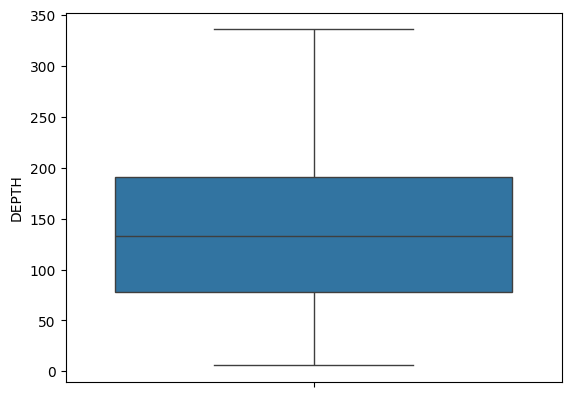

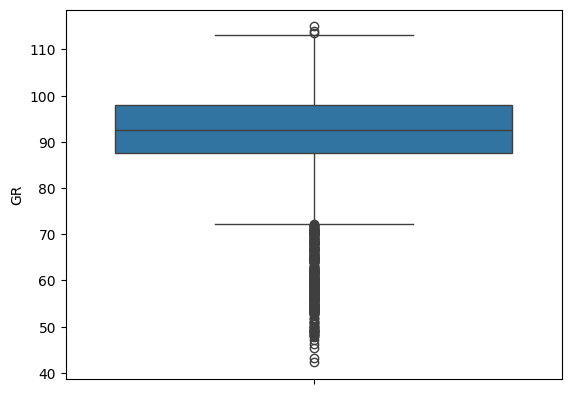

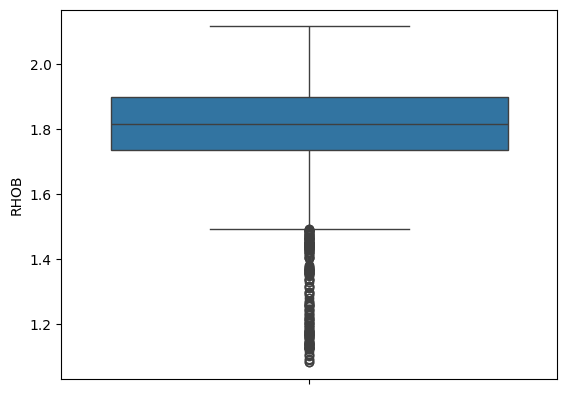

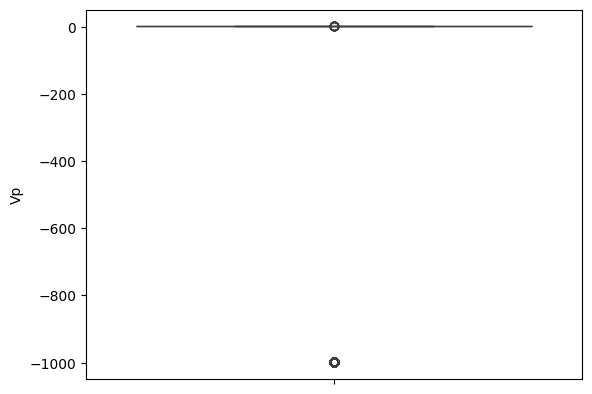

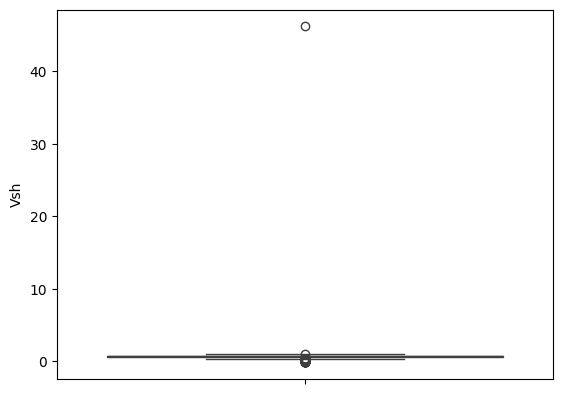

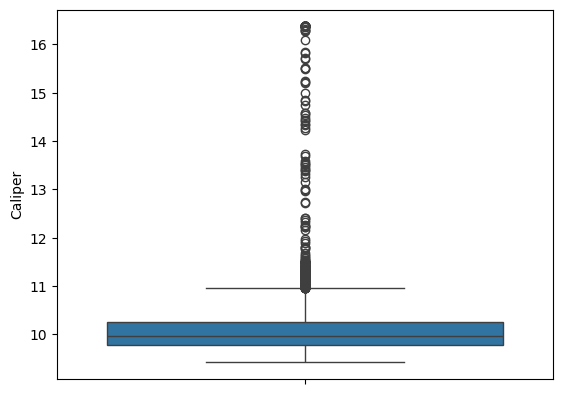

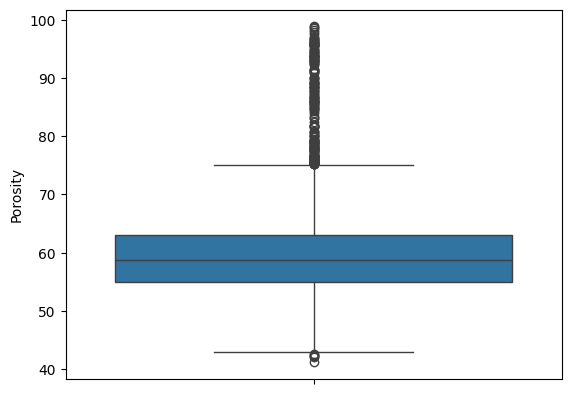

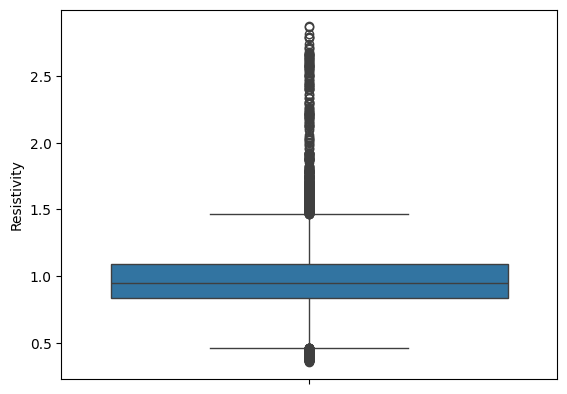

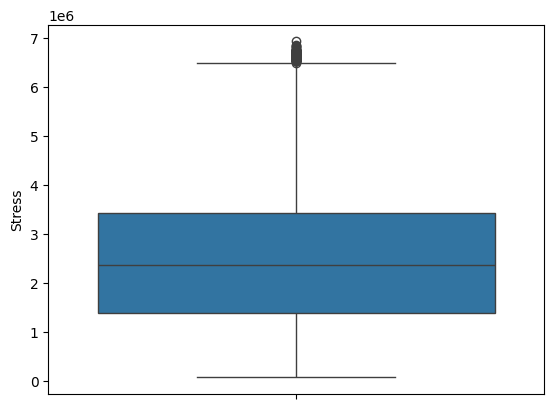

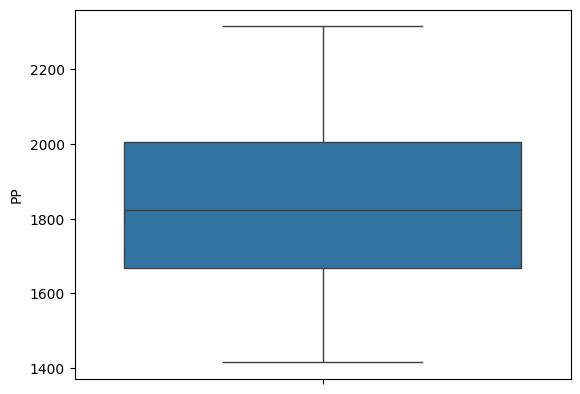

In [7]:
cols = a.columns

for col in cols:
    plt.figure()
    sns.boxplot(a[col])

The dataset contains 11,494 well-log readings across a depth range of ~6m to ~336m, 
reflecting shallow offshore sediment conditions typical of the KG Basin gas hydrate zones.
Key observations:
- No missing values in most features
- Vp contains 313 rows with the value -999.25, which is the standard null indicator 
  used in well-log datasets (LAS format convention) — these will be handled during 
  outlier treatment
- Porosity values averaging ~59% confirm shallow, unconsolidated marine sediments

In [8]:
# def remove_outliers_iqr(a, columns):
#     for col in columns:
#         Q1 = a[col].quantile(0.25)
#         Q3 = a[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         a[col] = np.where((a[col] < lower_bound) | (
#             a[col] > upper_bound), np.nan, a[col])
#     return a


# cols = a.columns
# a = remove_outliers_iqr(a, cols)

The standard IQR method was initially applied for outlier removal (see commented code 
above). However, this caused entire features to be replaced with NaN due to the 
tight value distributions in well-log data, leaving only 7 of 10 features usable.
Instead, domain-specific physical thresholds were applied based on known valid ranges 
for each sensor:
- GR < 70 API → invalid (below typical shale baseline)
- RHOB < 1.5 g/cc → invalid (below water density, physically impossible for sediment)
- Vp > 1.70 km/s → outlier AND Vp contains 313 rows with -999.25 (standard null 
  indicator in LAS well-log format) making it unreliable — dropped entirely later
- Vsh < 0.37 → below meaningful shale volume threshold
- Caliper > 11 inches → borehole washout indicator
- Porosity > 75% → physically unrealistic for consolidated sediment
- Resistivity > 1.5 ohm·m → anomalously high for this formation type

This approach retained all features while removing physically implausible readings.

In [9]:
a.loc[a['GR'] < 70, 'GR'] = np.nan
a.loc[a['RHOB'] < 1.5, 'RHOB'] = np.nan
a.loc[a['Vp'] > 1.70, 'Vp'] = np.nan
a.loc[a['Vsh'] < 0.37, 'Vsh'] = np.nan
a.loc[a['Caliper'] > 11, 'Caliper'] = np.nan
a.loc[a['Porosity'] > 75, 'Porosity'] = np.nan
a.loc[a['Resistivity'] > 1.5, 'Resistivity'] = np.nan

### Feature Selection — Dropping Vp

Vp (P-wave velocity) is removed from the feature set for two reasons:

1. **Data quality:** Vp contains 313 rows (2.72% of data) with the -999.25 null 
   indicator value, making it unreliable as a predictor.

2. **Near-zero correlation with target:** Correlation analysis shows Vp has a 
   correlation of only -0.008 with pore pressure (PP), making it the weakest 
   predictor among all features. Including it would add noise without improving 
   model performance.

The remaining features (Stress, DEPTH, RHOB, Resistivity, GR, Vsh, Caliper, 
Porosity) all show stronger correlation with PP and are retained.

In [10]:
a = a.dropna()

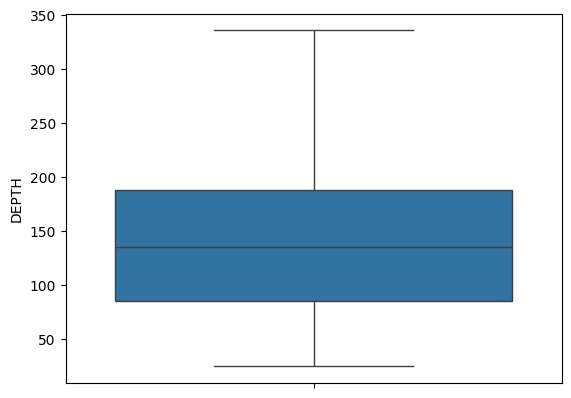

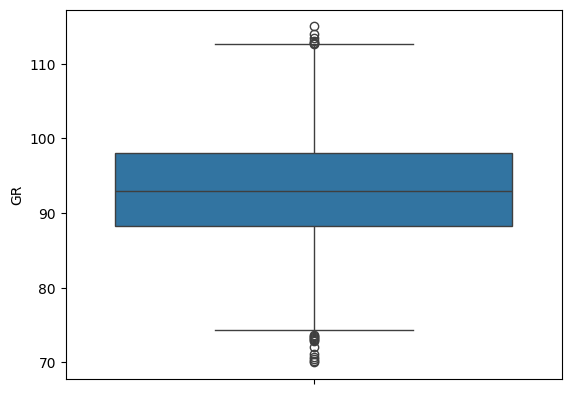

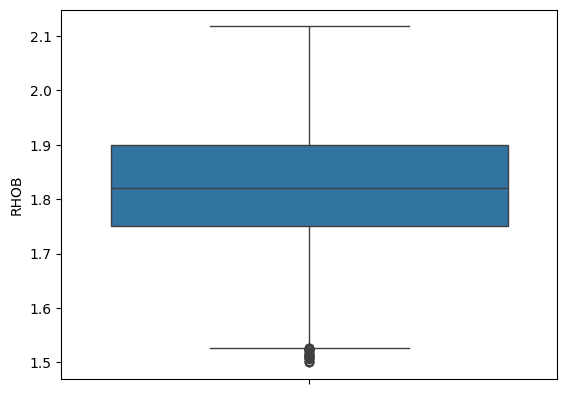

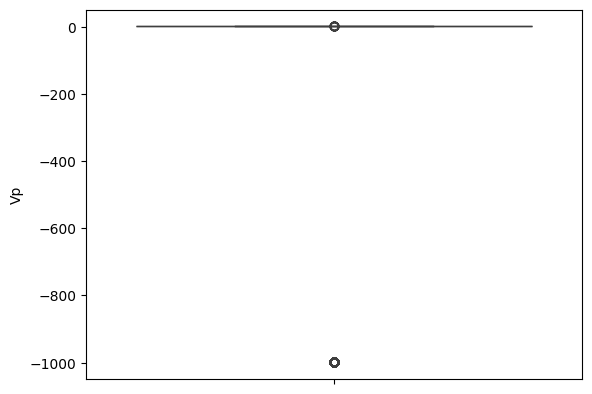

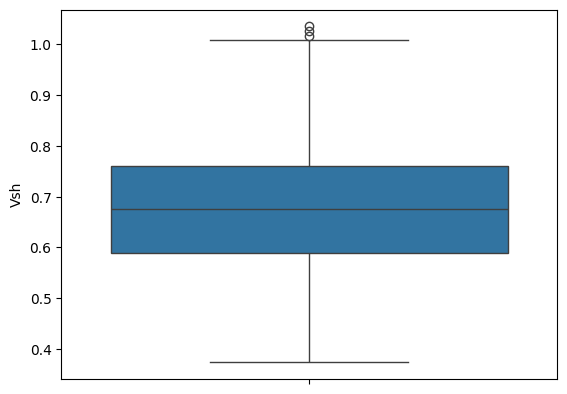

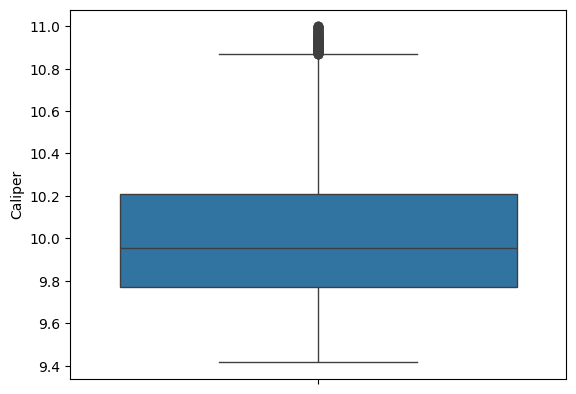

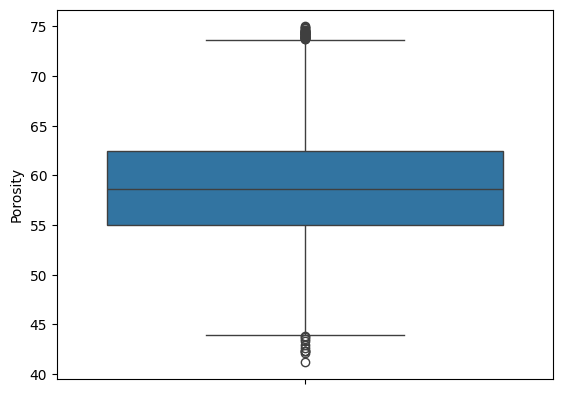

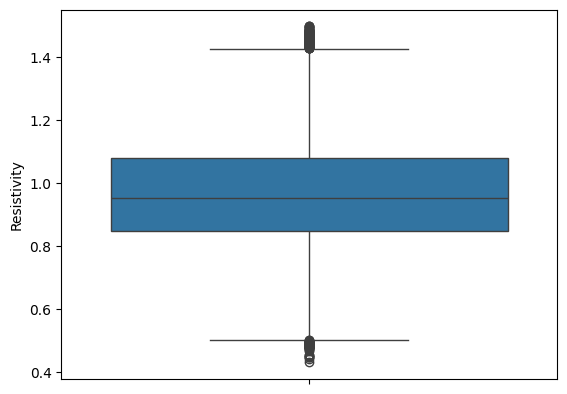

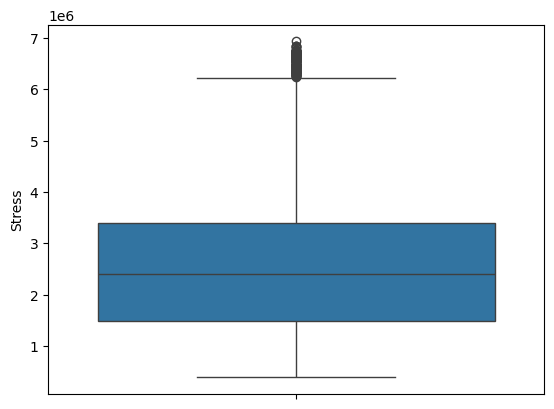

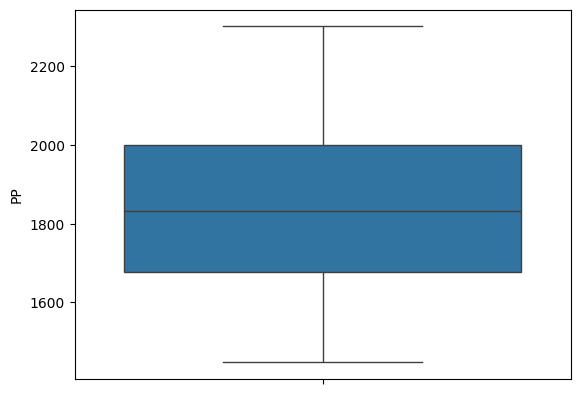

In [11]:
for col in cols:
    plt.figure()
    sns.boxplot(a[col])

Outliers are handled

In [12]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
scaled = scale.fit_transform(a[['GR', 'RHOB', 'Vsh', 'Caliper', 'Porosity',
                                'Resistivity', 'Stress']])

In [13]:
cols = ['GR', 'RHOB', 'Vsh', 'Caliper', 'Porosity',
        'Resistivity', 'Stress']
scaled_a = pd.DataFrame(scaled, columns=cols)

In [14]:
a = a.reset_index()

In [15]:
scaled_a

,GR,RHOB,Vsh,Caliper,Porosity,Resistivity,Stress
0,0.095351,0.087316,0.002970,0.937192,0.726727,0.314069,0.017649
1,0.277994,0.098007,0.187648,0.930059,0.804398,0.334395,0.018335
2,0.146424,0.144986,0.230534,0.858793,0.764288,0.363338,0.023780
3,0.047101,0.162644,0.173578,0.860497,0.803269,0.391064,0.024718
4,0.152046,0.136724,0.194618,0.917498,0.804055,0.391907,0.025682
...,...,...,...,...,...,...,...
10403,0.785251,0.543010,0.792334,0.335059,0.307047,0.641158,0.438688
10404,0.752223,0.525514,0.760394,0.313344,0.405877,0.649401,0.436171
10405,0.738662,0.506561,0.747281,0.258553,0.327461,0.659329,0.433404
10406,0.732966,0.477726,0.741773,0.277238,0.356041,0.671132,0.428971


In [16]:
merge = [a['DEPTH'], a['PP'], scaled_a]
pd.concat(merge, axis=1)
a_scaled = pd.concat(merge, axis=1)

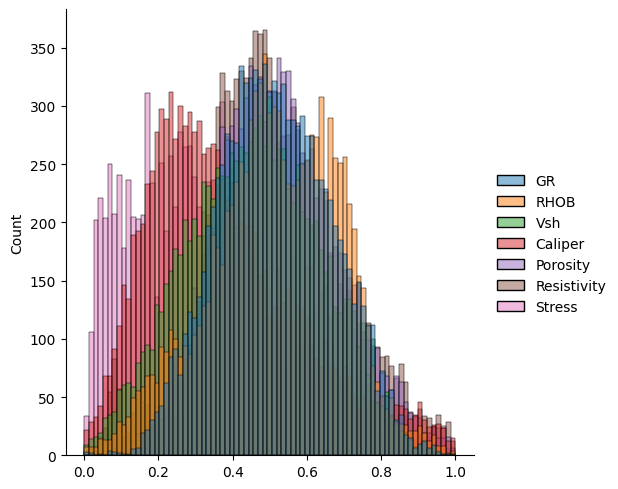

In [17]:
sns.displot(a_scaled[['GR', 'RHOB', 'Vsh', 'Caliper', 'Porosity',
                      'Resistivity', 'Stress']])

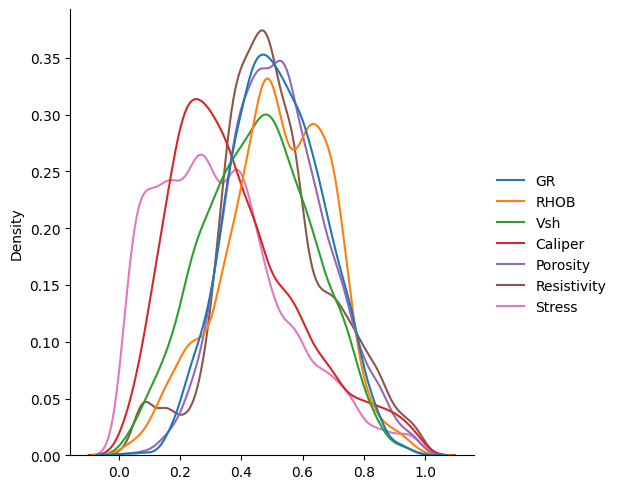

In [18]:
sns.displot(a_scaled[['GR', 'RHOB', 'Vsh', 'Caliper', 'Porosity',
                      'Resistivity', 'Stress']], kind="kde")

Our Data is ready for model development

In [19]:
# Feature engineering and selection
a = a_scaled.copy()
a

,DEPTH,PP,GR,RHOB,Vsh,Caliper,Porosity,Resistivity,Stress
0,33.2800,1617.0,0.095351,0.087316,0.002970,0.937192,0.726727,0.314069,0.017649
1,33.4324,1620.0,0.277994,0.098007,0.187648,0.930059,0.804398,0.334395,0.018335
2,35.1088,1621.0,0.146424,0.144986,0.230534,0.858793,0.764288,0.363338,0.023780
3,35.2612,1620.0,0.047101,0.162644,0.173578,0.860497,0.803269,0.391064,0.024718
4,36.0232,1622.0,0.152046,0.136724,0.194618,0.917498,0.804055,0.391907,0.025682
...,...,...,...,...,...,...,...,...,...
10403,181.3026,1805.0,0.785251,0.543010,0.792334,0.335059,0.307047,0.641158,0.438688
10404,181.4550,1805.0,0.752223,0.525514,0.760394,0.313344,0.405877,0.649401,0.436171
10405,181.6074,1803.0,0.738662,0.506561,0.747281,0.258553,0.327461,0.659329,0.433404
10406,181.7598,1808.0,0.732966,0.477726,0.741773,0.277238,0.356041,0.671132,0.428971


In [20]:
a.corr()

,DEPTH,PP,GR,RHOB,Vsh,Caliper,Porosity,Resistivity,Stress
DEPTH,1.000000,0.709591,0.228171,0.596943,0.183359,-0.470626,-0.529550,0.512857,0.995396
PP,0.709591,1.000000,0.297317,0.618000,0.327807,-0.467341,-0.562232,0.654209,0.725342
GR,0.228171,0.297317,1.000000,0.448181,0.928665,-0.216557,-0.427141,0.200921,0.249181
RHOB,0.596943,0.618000,0.448181,1.000000,0.447860,-0.482734,-0.870870,0.442243,0.653090
Vsh,0.183359,0.327807,0.928665,0.447860,1.000000,-0.237762,-0.435956,0.237863,0.206708
Caliper,-0.470626,-0.467341,-0.216557,-0.482734,-0.237762,1.000000,0.375908,-0.416026,-0.470615
Porosity,-0.529550,-0.562232,-0.427141,-0.870870,-0.435956,0.375908,1.000000,-0.407968,-0.578736
Resistivity,0.512857,0.654209,0.200921,0.442243,0.237863,-0.416026,-0.407968,1.000000,0.522337
Stress,0.995396,0.725342,0.249181,0.653090,0.206708,-0.470615,-0.578736,0.522337,1.000000


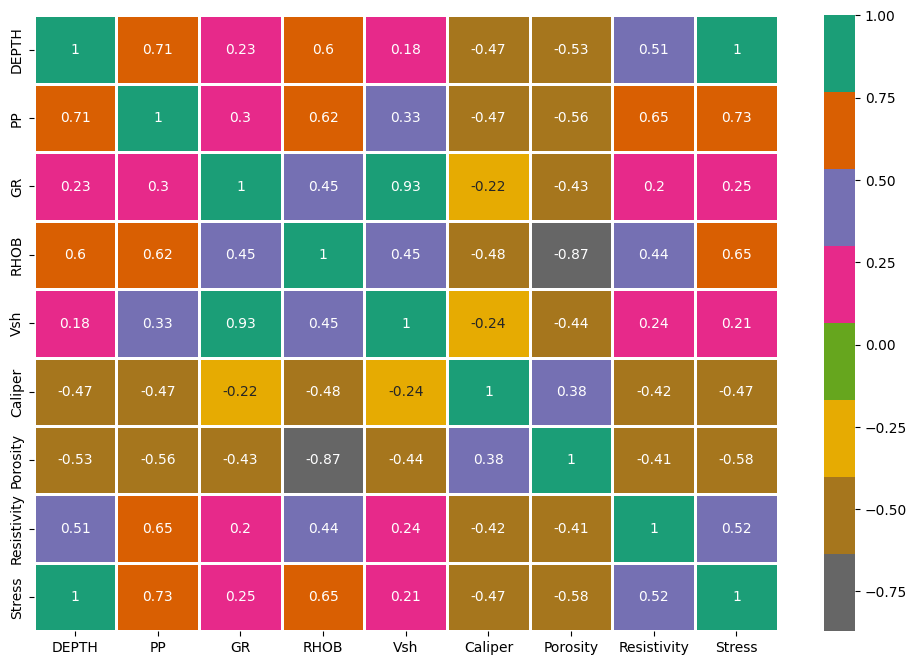

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(a.corr(), annot=True, cmap='Dark2_r', linewidths=2)
plt.show()

In [22]:
x = a.drop(['PP', 'DEPTH'], axis=1)  # independent variables
y = a['PP']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

print("Training data size:", x_train.shape)
print("Testing data size:", x_test.shape)

Training data size: (8326, 7)
Testing data size: (2082, 7)


### Models Used for Pore Pressure Prediction:
- Linear Regression (baseline)
- Random Forest Regressor
- XGBoost Regressor
- Support Vector Regressor (SVR)

Each model is evaluated using R², MAE, MSE and RMSE. Hyperparameter tuning 
is applied to the best performing models.

Linear Regression

Mean Squared Error (MSE): 14416.857029004264
Root Mean Squared Error (RMSE): 120.07021707735963
Mean Absolute Error (MAE): 93.10131083008797
R^2  Score: 0.6676129338187422
Coefficients: [-297.43510232  123.38338375  332.52928266  -40.15254195  -46.89092057
  361.05216309  447.15782287]
Intercept: 1489.5855597209775


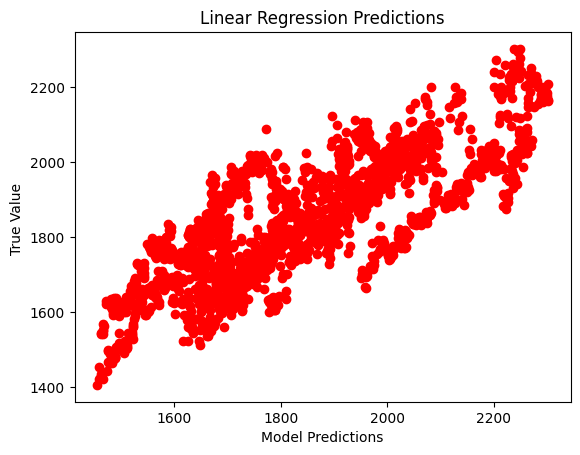

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2  Score:", r2)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

plt.plot(y_test, y_pred, "o", color='r')


plt.xlabel("Model Predictions")
plt.ylabel("True Value ")
plt.title('Linear Regression Predictions')
plt.show()

Linear Regression achieved R² = 0.67, performing poorly compared to ensemble 
methods. This confirms that the relationship between well-log sensor readings 
and pore pressure is non-linear, making tree-based models more suitable.

## Random Forest Regressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

rf_acc = r2_score(y_test, y_pred)
print("R^2", rf_acc)
print("Adusted R^2", 1-(1-r2_score(y_test, y_pred)) *
      (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 0.9522165026126449
Adusted R^2 0.9520552275491388
MAE 25.08440421277617
MSE 2072.54710026422
RMSE 45.52523586170883


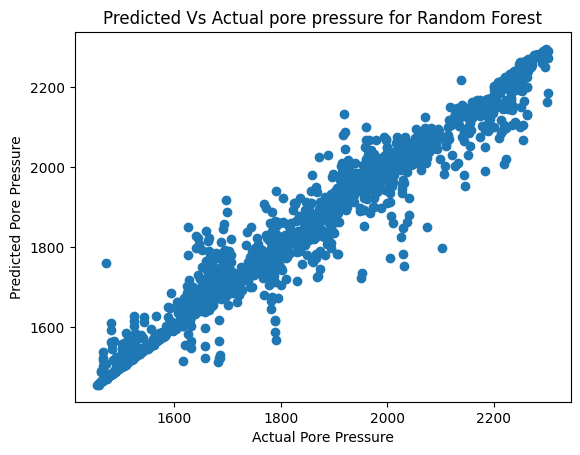

In [25]:
# visualization
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Pore Pressure")
plt.ylabel("Predicted Pore Pressure")
plt.title("Predicted Vs Actual pore pressure for Random Forest")
plt.show()

## XGB Regressor

In [26]:
from xgboost import XGBRegressor

xreg = XGBRegressor()
xreg.fit(x_train, y_train)
y_pred = xreg.predict(x_test)
xgb_acc = r2_score(y_test, y_pred)
print("R^2", xgb_acc)
print("Adusted R^2", 1-(1-r2_score(y_test, y_pred)) *
      (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE", mean_absolute_error(y_test, y_pred))
print("MSE", mean_squared_error(y_test, y_pred))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

R^2 0.9434525423284309
Adusted R^2 0.9432616878425577
MAE 32.96367858288679
MSE 2452.6724880447546
RMSE 49.52446353111515


## Support Vector Regressor (SVR)

R²: 0.6612173963568495
Adjusted R²: 0.6600739642326923
MAE: 92.75511959855794
MSE: 14694.255154843097
RMSE: 121.2198628725635


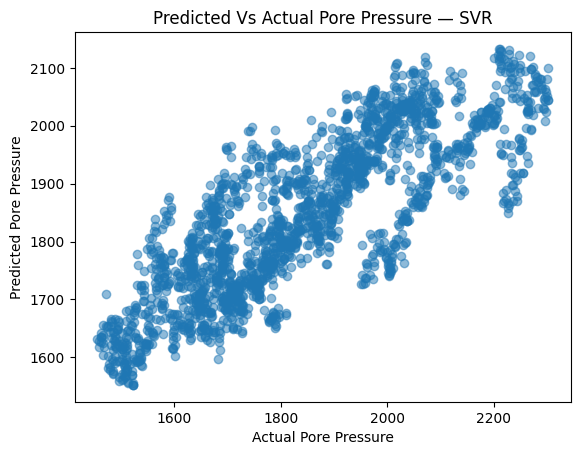

In [27]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(x_train, y_train)
y_pred_svr = svr.predict(x_test)

svr_acc = r2_score(y_test, y_pred_svr)
print("R²:", svr_acc)
print("Adjusted R²:", 1-(1-svr_acc) *
      (len(y_test)-1)/(len(y_test)-x_test.shape[1]-1))
print("MAE:", mean_absolute_error(y_test, y_pred_svr))
print("MSE:", mean_squared_error(y_test, y_pred_svr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_svr)))

plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.xlabel("Actual Pore Pressure")
plt.ylabel("Predicted Pore Pressure")
plt.title("Predicted Vs Actual Pore Pressure — SVR")
plt.show()

SVR with RBF kernel achieved R² = 0.66 on this dataset, performing similarly 
to Linear Regression. This is because SVR is sensitive to the scale and 
distribution of features, and the complex non-linear relationships in 
geophysical sensor data are better captured by ensemble tree-based methods 
like Random Forest. SVR is included here as a benchmark for comparison.

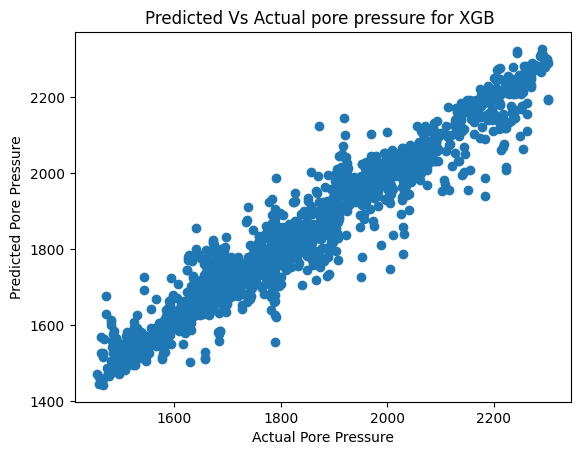

In [28]:
# visualization
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Pore Pressure")
plt.ylabel("Predicted Pore Pressure")
plt.title("Predicted Vs Actual pore pressure for XGB ")
plt.show()

               Model  R_squared Score
0      Random Forest        95.221650
1            XGBoost        94.345254
2  Linear Regression        66.761293
3                SVR        66.121740


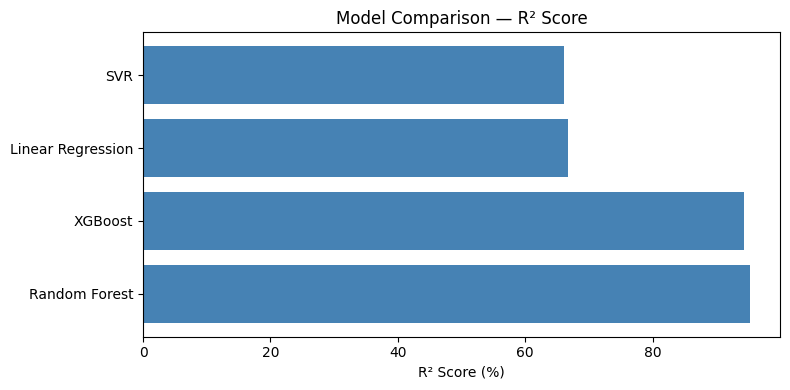

In [29]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'SVR'],
    'R_squared Score': [r2*100, rf_acc*100, xgb_acc*100, svr_acc*100]
})
models = models.sort_values(
    by='R_squared Score', ascending=False).reset_index(drop=True)
print(models)

# Visual comparison
plt.figure(figsize=(8, 4))
plt.barh(models['Model'], models['R_squared Score'], color='steelblue')
plt.xlabel('R² Score (%)')
plt.title('Model Comparison — R² Score')
plt.tight_layout()
plt.show()

### Feature Importance Analysis

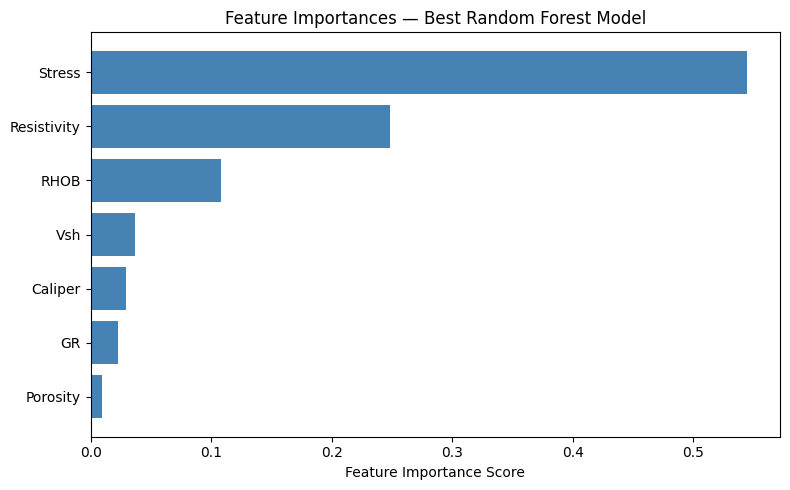


Feature Importance Ranking:
  Stress: 0.5449
  Resistivity: 0.2481
  RHOB: 0.1086
  Vsh: 0.0370
  Caliper: 0.0290
  GR: 0.0231
  Porosity: 0.0095


In [30]:
importances = reg.feature_importances_
feature_names = x.columns
indices = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(indices)), importances[indices], color='steelblue')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances — Best Random Forest Model')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i in reversed(indices):
    print(f"  {feature_names[i]}: {importances[i]:.4f}")

## Hypertuning

Random Forest

In [31]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [32]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

rf_search.fit(x_train, y_train)
print("Best RF Parameters:", rf_search.best_params_)

rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(x_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest R²: {r2_rf:.3f}")

Best RF Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
Random Forest MAE: 36.025
Random Forest RMSE: 54.349
Random Forest R²: 0.932


In [33]:
from sklearn.model_selection import cross_val_score, KFold

# Default model
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(x_train, y_train)
default_r2 = r2_score(y_test, rf_default.predict(x_test))
print(f"Default RF R² on test set: {default_r2:.3f}")

# Cross-validation with shuffling for robustness
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_default = cross_val_score(rf_default, x, y, cv=kf, scoring='r2')
print(f"Default RF mean CV R²: {cv_scores_default.mean():.3f}")

# Tuned model
rf_best = rf_search.best_estimator_
tuned_r2 = r2_score(y_test, rf_best.predict(x_test))
print(f"Tuned RF R² on test set: {tuned_r2:.3f}")

cv_scores_tuned = cross_val_score(rf_best, x, y, cv=kf, scoring='r2')
print(f"Tuned RF mean CV R²: {cv_scores_tuned.mean():.3f}")

Default RF R² on test set: 0.949
Default RF mean CV R²: 0.951
Tuned RF R² on test set: 0.932
Tuned RF mean CV R²: 0.932


XGBoost 

In [34]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)
xgb_search.fit(x_train, y_train)


print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Lowest RMSE found:", np.sqrt(np.abs(xgb_search.best_score_)))

xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(x_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost MAE: {mae_xgb:.3f}")
print(f"XGBoost RMSE: {rmse_xgb:.3f}")
print(f"XGBoost R²: {r2_xgb:.3f}")

Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Lowest RMSE found: 54.80168920118167
XGBoost MAE: 36.248
XGBoost RMSE: 53.359
XGBoost R²: 0.934


The default Random Forest model achieved R² = 0.95 on the test set. After 
hyperparameter tuning using RandomizedSearchCV with 5-fold cross-validation, 
the tuned Random Forest achieved R² = 0.93 with best parameters: 
n_estimators=300, max_depth=20, max_features='log2'. The slight decrease from 
0.95 to 0.93 indicates the tuned model generalises better by avoiding 
overfitting to the training data. XGBoost similarly achieved R² ≈ 0.93 after 
tuning, confirming that both ensemble methods are well-suited for this 
geophysical sensor regression task.

This study applied machine learning models to well-log sensor data from the 
Krishna-Godavari (KG) Basin, India, to estimate pore pressure as a data-driven 
alternative to direct measurement.

**Key findings:**
- Linear Regression performed poorly, confirming non-linear relationships exist 
  between sensor readings and pore pressure
- Random Forest and XGBoost both achieved strong performance with R² ≈ 0.93 
  after hyperparameter tuning using RandomizedSearchCV with 5-fold cross-validation
- SVR provided an additional benchmark for comparison
- Feature importance analysis showed that Stress, RHOB, and Resistivity were 
  the strongest predictors of pore pressure, consistent with geomechanical theory
- Vp was excluded due to data quality issues (2.72% null indicators) and 
  near-zero correlation with the target variable

**Takeaway:** ML-based pore pressure estimation from well-log sensor data is 
a viable, cost-effective approach for subsurface geomechanical analysis, 
particularly in data-rich environments like the KG Basin offshore India.